<a href="https://colab.research.google.com/github/Spica08/Deep-Learning-from-Scratch/blob/main/7%E7%AB%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#setup
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import pickle
from tqdm import tqdm
from collections import OrderedDict

In [2]:
#function

#恒等関数
def identity_function(x):
    return x

#ステップ関数
def step_function(x):
  y = x > 0
  return y.astype(int)

#シグモイド関数
def sigmoid(x):
  return 1/(1+np.exp(-x))

#ReLU関数
def ReLU(x):
  return np.maximum(0,x)

#ソフトマックス関数
def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

#2乗和誤差
def mean_square_error(y, t):
  return 0.5 * np.sum((y-t)**2)

#交差エントロピー誤差
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x) # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val # 値を元に戻す
        it.iternext()

    return grad

In [3]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

In [4]:
class Relu:
  def __init__(self):
    self.mask = None

  def forward(self, x):
    self.mask = (x <= 0)
    out = x.copy()
    out[self.mask] = 0
    return out

  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout
    return dx

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b

        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx

class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None #softmaxの出力
    self.t = None #教師データ

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)
    return self.loss

  def backward(self, dout = 1):
    batch_size = self.t.shape[0]
    if self.t.size == self.y.size:
      dx = (self.y - self.t) / batch_size
    else:
      dx = self.y.copy()
      dx[np.arange(batch_size), self.t] -= 1
      dx = dx / batch_size
    return dx

In [5]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング

    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad

    Returns
    -------

    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]


# 7章 畳み込みニューラルネットワーク


## 7.1 全体の構造
CNNでは、新たに「Convolution layer (畳み込み層)」「Pooling layer (プーリング層)」が登場する。  
これまでのニューラルネットワークでは、隣接する層の全てのニューロン間で結合があり、これを**全結合**と呼ぶ。これまででは全結合層をAffineレイヤとして実装した。そこでは、「Affine - ReLU」を何層か重ね、最後に「Affine - Softmax」を通すことで確率を出力した。  
CNNでは、新たに「Convolution - ReLU - (Pooling)」といった層が加わる。また、出力に近い層ではこれまで通り「Affine - ReLU」や「Affine - Softmax」が用いられる。

## 7.2 畳み込み層


### 7.2.1 全結合層の問題点
全結合層では、隣接する層のニューロンが全て連結されており、出力の数は任意に決めることができる。  
問題点としては、データの「形状」が無視されてしまう点が挙げられる。例えば3次元の画像データを全結合層に通す時、1次元化する必要がある。  
一般に、画像は3次元の形状であり、この形状には大切な空間的情報が含まれている。空間的に近いピクセルは似たような値だったり、RGBの各チャンネルにはそれぞれ密接な関連性があったり、距離の離れたピクセル同士はあまり関連がなかったり、などである。しかし全結合層では全ての入力データを同等のニューロンとして扱うので、形状に関する情報を活かすことができない。  
一方畳み込み層(Convolution layer) は形状を維持する。画像の場合、データを3次元データとして受け取り、同じく3次元のデータとして次の層に出力する。そのためCNNでは、画像などの形状を有したデータを正しく理解できる可能性がある。  
用語として、畳み込み層の入出力データを**特徴マップ**、入力データと出力データはそれぞれ**入力特徴マップ**、**出力特徴マップ**と呼ぶ。

### 7.2.2 畳み込み演算
畳み込み層では「畳み込み演算」、画像処理でいうところの「フィルター演算」を行う。  
畳み込み演算では、入力データに対してフィルター(カーネル)を適用する。具体的には、入力データに対してフィルターのウィンドウを一定の間隔でスライドさせながら適用する。それぞれの場所ではフィルターの要素と、入力データの対応する要素を乗算し、その和を求める。これにバイアスを加えたものが演算結果として出力される。

### 7.2.3 パディング
畳み込み層の処理を行う前に、入力データの周囲に固定のデータ(0など)を埋めることがある。これを**パディング**という。これを使う主な理由としては、出力データの形状を調整することが挙げられる。パディングにより、畳み込み演算によりデータが空間的に縮小することを防ぐことができる。

### 7.2.4 ストライド
フィルターを適用する位置の間隔を**ストライド**という。ストライドによっても、出力データの形状は変化する。  
ここで、入力サイズを(H, W)、フィルターサイズを(FH, FW)、パディングをP、ストライドをSとした時に出力サイズがどのように変化するかを考える。数式では以下のように表される。  
$OH = \frac{H + 2P - FH}{S} + 1$  
$OW = \frac{W+ 2P - FW}{S} + 1$
実装の際には、これらが割り切れない時はエラーを出力するなどして対応する必要がある。

### 7.2.5 3次元データの畳み込み演算
3次元データに対しても同様に畳み込み演算を行うことができる。その際フィルターにもチャンネル方向の次元が加わった3次元のフィルターを用いる。

### 7.2.6 ブロックで考える
3次元データやフィルターを多次元配列として表すときは、(channel, height, width)の順に並べて書くこととする。  
ここで、(C, H, W)の入力データと(C, FH, FW)のフィルターの畳み込み演算では、(1, OH, OW)の形状を持った出力データが得られる。この出力をチャンネル方向にも持たせるには、複数のフィルターを用いる。(C, H, W)の入力データに対してFN個のフィルター(FN, C, FH, FW)を適用すると、(FN, OH, OW)の出力が得られる。ここで、畳み込み演算ではバイアスも存在する。バイアスは1チャネルごとにひとつだけデータを持つ。(FN, OH, OW)の出力に対してバイアスの形状は(FN, 1, 1)となる。

### 7.2.7 バッチ処理
略

## 7.3 プーリング層
プーリングとは、縦・横方向の空間を小さくする演算である。例えば、2x2の領域を1つの集約するような演算を行うことで空間サイズを小さくする。演算としては「Max pooling」「average pooling」などが存在し、一般的にウィンドウサイズとストライドを同じ値に設定する。

### 7.3.1 プーリング層の特徴
プーリング層には以下の特徴がある。  
1. 学習するパラメータがない  
2. チャンネル数は変化しない  
3. 微小な位置変化に対してロバスト

## 7.4 Convolution/Poolingレイヤの実装


### 7.4.1 4次元配列
CNNでは、4次元データを扱うことになる。

In [6]:
x = np.random.rand(10, 1, 28, 28)
print(x.shape)

(10, 1, 28, 28)


### 7.4.2 im2colによる展開
畳み込み演算の実装は、ナイーブな実装ではfor 文を複数重ねた実装になるが、面倒で速度も遅い。ここではim2col関数を使ったシンプルな実装を行う。  
im2colは、フィルターにとって都合が良いように入力データを展開する。具体的には、入力データに対してフィルターを適用する場所の領域を1列に展開する。この展開のためにim2colでは通常よりも多くメモリを消費するが、行列計算は高度に最適化されており、速度面での恩恵を受けることもできる。  
入力データの展開後は、フィルターも1列に展開して2つの行列の積を計算するだけである。

### 7.4.3 Convolution レイヤの実装
今回はim2colの実装は省略し、実際に使ってみるところから始める。

In [7]:
x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride = 1, pad = 0)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride = 1, pad = 0)
print(col2.shape)

(9, 75)
(90, 75)


In [6]:
#Convolutionの実装
class Convolution:
    def __init__(self, W, b, stride = 1, pad = 0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

        # 中間データ（backward時に使用）
        self.x = None
        self.col = None
        self.col_W = None

        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape # weight
        N, C, H, W = x.shape # data
        out_h = int(1 + (H + 2 * self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2 * self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad) # (N * out_h * out_w) * (C, FH, FW)
        col_W = self.W.reshape(FN, -1).T # (C * FH * FW) * FN
        out = np.dot(col, col_W) + self.b # (N * out_h * out_w) * FN

        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

### 7.4.4 Pooling レイヤの実装
Convolution同様にim2colを使って実装するが、チャンネルごとに操作が独立である点に注意する。

In [7]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride = 1, pad = 0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape # data
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad) # (N * out_h * out_w) * (C, pool_h, pool_w)
        col = col.reshape(-1, self.pool_h * self.pool_w) # (N * out_h * out_w * C) *  (pool_h, pool_w)
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis = 1) # (N * out_h * out_w * C) *  (1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1) # N * out_h * out_w * C

        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size)) # (N * out_h * out_w * C) * (pool_h * pool_w)
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) # N * out_h * out_w * C * (pool_h * pool_w)

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1) # (N * out_h * out_w) * (C * pool_h * pool_w)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

        return dx

## 7.5 CNNの実装
「Convolution - ReLU - Pooling - Affine - ReLU - Affine - Softmax」というアーキテクチャでCNNを構成する。

In [8]:
class SimpleConvNet:
    def __init__(self, input_dim = (1, 28, 28),
                 conv_param = {"filter_num" : 30, "filter_size" : 5, "pad" : 0, "stride" : 1}, hidden_size = 100, output_size = 10, weight_init_std = 0.01):
        filter_num = conv_param["filter_num"]
        filter_size = conv_param["filter_size"]
        filter_pad = conv_param["pad"]
        filter_stride = conv_param["stride"]
        input_size = input_dim[1]
        conv_output_size  = (input_size - filter_size + 2 * filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2))

        self.params = {}
        #Convolution
        self.params["W1"] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params["b1"] = np.zeros(filter_num)
        #Affine
        self.params["W2"] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params["b2"] = np.zeros(hidden_size)
        self.params["W3"] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params["b3"] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers["Conv1"] = Convolution(self.params["W1"], self.params["b1"], conv_param["stride"], conv_param["pad"])
        self.layers["Relu1"] = Relu()
        self.layers["Pool1"] = Pooling(pool_h = 2, pool_w = 2, stride = 2)
        self.layers["Affine1"] = Affine(self.params["W2"], self.params["b2"])
        self.layers["Relu2"] = Relu()
        self.layers["Affine2"] = Affine(self.params["W3"], self.params["b3"])
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        if t.ndim != 1:
            t = np.argmax(t, axis = 1)
        accuracy = np.sum((y == t)) / float(x.shape[0])
        return accuracy

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        #backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout =  layer.backward(dout)

        grads = {}
        grads["W1"] = self.layers["Conv1"].dW
        grads["b1"] = self.layers["Conv1"].db
        grads["W2"] = self.layers["Affine1"].dW
        grads["b2"] = self.layers["Affine1"].db
        grads["W3"] = self.layers["Affine2"].dW
        grads["b3"] = self.layers["Affine2"].db

        return grads

In [9]:
#データ準備
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# mnist.pyをインポート
sys.path.append("/content/drive/MyDrive/Colab Notebooks/ゼロから作るDeep Learning")
from mnist import load_mnist

In [11]:
#データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten = False, normalize = True, one_hot_label = True)
x_train, t_train = x_train[:10000], t_train[:10000]
x_test, t_test = x_test[:1000], t_test[:1000]

# 学習過程でのlossを保存
train_loss_list = []
train_acc_list = []
test_acc_list = []

#ハイパーパラメータ
iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

#1エポックあたりの繰り返し数
iter_per_epoch = max(train_size / batch_size, 1)

#モデルの定義
network = SimpleConvNet(input_dim=(1,28,28),
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

optimizer = Adam(lr = 0.001)

#ミニバッチ学習
for i in tqdm(range(iters_num)):
    #ミニバッチ取得
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    #勾配計算
    grad = network.gradient(x_batch, t_batch)

    #パラメータ更新
    optimizer.update(network.params, grad)

    #学習過程の記録
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test, acc | " + str(train_acc) +", " + str(test_acc))

  0%|          | 1/1000 [00:20<5:36:38, 20.22s/it]

train acc, test, acc | 0.2937, 0.254


 10%|█         | 101/1000 [01:27<1:23:12,  5.55s/it]

train acc, test, acc | 0.8985, 0.872


 20%|██        | 201/1000 [02:42<1:24:19,  6.33s/it]

train acc, test, acc | 0.9176, 0.889


 30%|███       | 301/1000 [03:48<56:35,  4.86s/it]

train acc, test, acc | 0.9448, 0.94


 40%|████      | 401/1000 [04:58<1:01:37,  6.17s/it]

train acc, test, acc | 0.9624, 0.947


 50%|█████     | 501/1000 [06:13<53:35,  6.44s/it]

train acc, test, acc | 0.9667, 0.953


 60%|██████    | 601/1000 [07:21<39:08,  5.89s/it]

train acc, test, acc | 0.9775, 0.966


 70%|███████   | 701/1000 [08:32<28:16,  5.67s/it]

train acc, test, acc | 0.9767, 0.964


 80%|████████  | 801/1000 [09:39<18:42,  5.64s/it]

train acc, test, acc | 0.9832, 0.962


 90%|█████████ | 901/1000 [10:49<08:42,  5.27s/it]

train acc, test, acc | 0.9869, 0.973


100%|██████████| 1000/1000 [11:40<00:00,  1.43it/s]


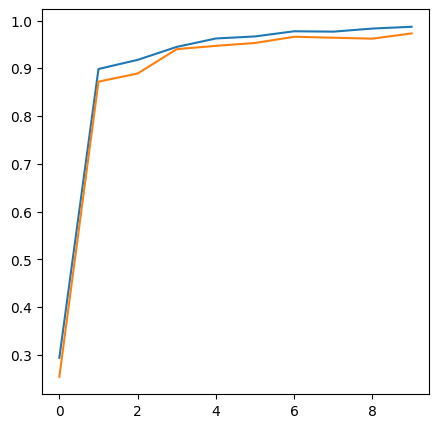

In [12]:
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(np.arange(len(train_acc_list)), train_acc_list)
ax.plot(np.arange(len(test_acc_list)), test_acc_list)
fig.show()

簡単な学習でも全結合層のみのニューラルネットワークよりも高い性能が出た。

In [13]:
# パラメータの保存
params = {}
for key, val in network.params.items():
    params[key] = val
with open("params.pkl", 'wb') as f:
    pickle.dump(params, f)
print("Saved Network Parameters!")

Saved Network Parameters!


## 7.6 CNNの可視化

### 7.6.1 1層目の重みの可視化
ここまでで、サイズが(5, 5)のフィルター30個を用いて学習をおこなった。ここで、各フィルターの重みを学習前後で比べてみる。

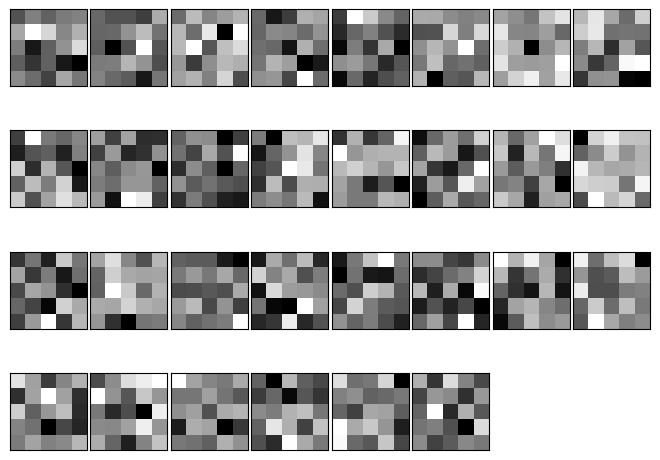

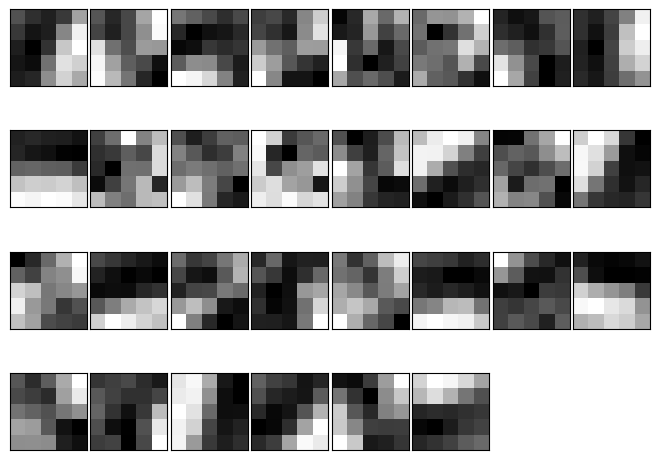

In [15]:
def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network_init = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network_init.params['W1'])

# 学習後の重み
trained_params = {}
with open("params.pkl", 'rb') as f:
    weight = pickle.load(f)
    for key, val in params.items():
        trained_params[key] = val
filter_show(trained_params['W1'])

学習前のフィルターには規則性が見られないが、学習後のフィルターには規則性が見られる。白から黒へグラデーションを伴って変化するフィルターや、塊のある領域(blob)などが確認できた。  
これらの規則は何を見ているのかというと、エッジやブロブなどである。例えば左半分が白で右半分が黒であるようなフィルターは、縦方向のエッジに対応するフィルターだと捉えることができる。

### 7.6.2 階層構造による情報抽出
上の結果はCNNの1層目の結果だったが、より何層にも重ねたCNNでは、層が深くなるにつれてより抽象化された情報が抽出されることが知られている。  
例えばAlexNetといった複雑なモデルでは、1層目でエッジ、3層目でテクスチャ、5層目で物体のパーツ、といったようにより高度な情報を表すようになる。

## 7.7 代表的なCNN

### 7.7.1 LeNet
1998年に提案されたモデル。プーリング層では、要素を間引くサンプリングを行なっており、活性化関数にシグモイド関数が採用されているなどの点で現在主流のCNNとは異なる。

### 7.7.2 AlexNet
2012年に発表された。LeNetと比較して、活性化関数にはReLU、LRNという局所的正規化、Dropoutを使用、などの違いがある。